# EXAMPLE USE OF THE ml_edm PACKAGE

Many situations require decisions to be made quickly to avoid the costs associated with delaying the decision. A doctor who needs to choose which test to perform on their patient and an agent considering whether a certain behavior on a network is caused by a hacker are examples of individuals confronted with such situations. However, taking a decision too hastily may lead to more mistakes, resulting in additional costs that could have been avoided. 

In these situations, where there is a trade-off between the earliness of the decision and the accuracy of the prediction, the Machine Learning for Early Decision Making (ML-EDM) framework offers AI solutions not only to make a prediction but also to decide when to trigger its associated decision.

The ml_edm package provides tools to facilitate dealing with the early classification of time series (ECTS) problem, whose goal is to determine the class associated with a time series before it reaches its last timestamp/measurement T as early as possible.

To do this, the EarlyClassifier class combines a series of classifiers (ChronologicalClassifiers instance) and a trigger model (EconomyGamma instance) in one object (EarlyClassifier isntance):

- The chronological classifiers object predicts classes of time series by selecting one of many classifiers trained on time series of different input lengths to be able to give a prediction at different timestamps.
- The trigger model takes as input the predicted class probability vectors of a time series and a series of costs associated with the time and nature of the prediction. It outputs the indication to either trigger the decision now or delay it. 

You can either use these two objects together through the EarlyClassifier class for a straightforward and simple experience or separately if you need more control. This notebook details the two approaches below.

Please note that this version of the library does not deal with multivariate time series yet. Please also note that the feature extraction implemented in this version is far from optimized. We recommand experimenting with it before using it.

For more detail about ML-EDM, check this publication:

Open challenges for Machine Learning based Early Decision-Making research, Alexis Bondu, Youssef Achenchabe, Albert Bifet, Fabrice Clérot, Antoine Cornuéjols, Joao Gama, Georges Hébrail, Vincent Lemaire, Pierre-François Marteau. ArXiv 2022.

For other references check the ML-EDM GitHub:
https://github.com/ML-EDM/ML-EDM.

## Initialisation

#### Imports

In [1]:
from classification import EarlyClassifier, ChronologicalClassifiers
from trigger_models import EconomyGamma, create_cost_matrices

import numpy as np
from sktime import datasets
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier

#### Data preparation

The dataset we use for this demonstration is the "ItalyPowerDemand" dataset from the UCR UEA time series repository.
It is composed of 1096 univariate time series of 24 measurements distributed unequally between a train and test set.
For the purpose of our demonstration we distributed the time series equally between the train and test set.
You may find all datasets from the UCR UEA repository on this website:
https://www.timeseriesclassification.com

In [2]:
X, y = datasets.load_UCR_UEA_dataset("ItalyPowerDemand") # Get dataset
X  = np.vstack(X["dim_0"].apply(lambda x: x.values)) # Convert to numpy array
# separate train test
test_index = int(.5*len(X))
train_x, train_y = X[:test_index], y[:test_index]
test_x, test_y = X[test_index:], y[test_index:]

print(train_x.shape)
print(test_x.shape)

(548, 24)
(548, 24)


## Early Prediction using classification.EarlyClassifier 

The EarlyClassifier object combines a ChronologicalClassifier instance and a trigger model (EconomyGamma instance by default) for the classification of incomplete time series and prediction of their triggering time. For more technical usages, these two objects may be used separately.

EconomyGamma is a highly performing trigger model for early classification caracterized by its non-myopic ability to estimate what will be the costs of delaying the decision in the future. For more detail on the inner workings of the model check this publication:

Early classification of time series, Youssef Achenchabe, Alexis Bondu, Antoine Cornuéjols, Asma Dachraoui. Machine Learning 110.6 (2021): 1481-1504.

#### Defining costs:

The first step to using the EarlyClassifier class is to define the misclassification cost and delay cost.

 misclassification_cost: numpy.ndarray
    Array of size Y * Y where Y is the number of classes and where each value at indices
    [i,j] represents the cost of predicting class j when the actual class is i. Usually, diagonals of the
    matrix will be all zeros. 
    
delay_cost: python function
        Function that takes as input a time series input length and returns the timely cost of waiting
        to obtain such number of measurements given the task.
        
These costs should be defined by a domain expert and must be expressed in the same unit.

In [3]:
misclassification_cost = [[0, 10],
                          [10, 0]]

def delay_cost(series_length):
    return series_length * .1

#### Instanciation

The EarlyClassifier object may be instiantiated by providing the misclassification_cost and the delay_cost.
Other possible parameters are:

- nb_classifiers: number of different time series input length to train classifiers on (DEFAULT=20)
- nb_intervals: An hyperparameter corresponding to the number of groups to aggregate the training time series into using EconomyGamma (DEFAULT=5).
- base_classifier:Classifier instance to be cloned and trained for each input length (DEFAULT=HistGradientBoostingClassifier())
- learned_timestamps_ratio: Proportion of equally spaced time measurements to use for training. (DEFAULT=NONE)
- chronological_classifiers: Use of custom ChronologicalClassifiers object
- trigger_model: Use of custom trigger model instance.

In [4]:
ec = EarlyClassifier(misclassification_cost, delay_cost)

#### Model Fitting

The training is done by giving the training data X and label array y. Optionnally, the proportion of validation data may be precised. 

- X: Training set of matrix shape (N, T) where:
                N is the number of time series ;
                T is the commune length of all complete time series.
- y: List or array of the N corresponding labels of the training set.
- val_proportion: Proportion of data to be used by the trigger_model for training.

In [5]:
ec.fit(train_x, train_y)

Using 'nb_classifiers=20 by default.


#### get_params
Function get_params returns a dictionary object detailing all attributes of the ChronologicalClassifier and trigger model instances used by the EarlyClassifier object.

All attributes in the object can be accessed through syntax such as: ec.chronological_classifiers.[ATTRIBUTE] or ec.trigger_model.[ATTRIBUTE]

Details about all attributes can be found in the code documentation of the corresponding classes.


In [6]:
ec.get_params()

{'classifiers': [HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier()],
 'models_input_lengths': array([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 18, 19, 20,
        21, 22, 24]),
 'base_classifier': HistGradientBoostingClassifier(),
 'nb_classifiers': 20,
 'learned_timestamps_ratio': None,
 'misclassification_cost': [[0

#### Assess the information gain:

In order for early classification to be useful, there need to be a gain in information as time series measurements are obtained. To avoid unnecessary computational costs, we recommand to assess this information gain on the trained classifiers early on.

Here we compute the evolution of the classifiers' accuracy over the 50 first time series of the test set as new measurements are added along time.

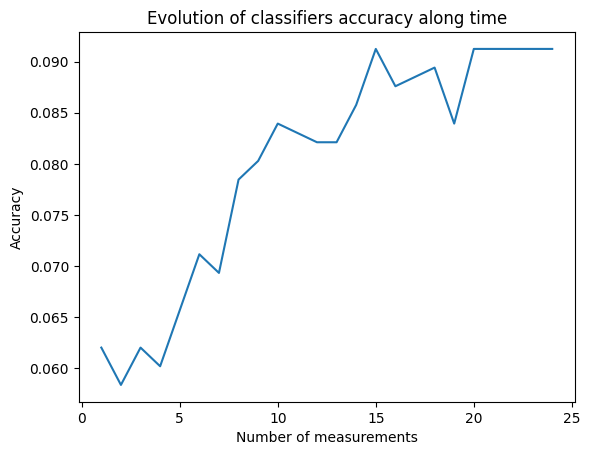

In [7]:
classes = [ec.predict(test_x[:50, :length])[0] for length in ec.chronological_classifiers.models_input_lengths]
scores = [np.count_nonzero(model_classes==test_y[:50])/test_y.shape[0] for model_classes in classes]
plt.xlabel("Number of measurements")
plt.ylabel("Accuracy")
plt.title("Evolution of classifiers accuracy along time")
plt.plot(ec.chronological_classifiers.models_input_lengths, scores)


#### Predicting

We now truncate each time series in the test dataset to a random size and use our early classifier to obtain the predicted data for all time series.

Input is a dataset of time series of various sizes to predict as an array of shape (N * max_T) where N is the number of time series, max_T the max number of measurements in a time series and where empty values are filled with nan. 

The dataset can also be a pandas DataFrame or a list of lists.

The predict method outputs 4 objects:
- classes: Array containing the predicted class of each time series in X.
- probas: Array containing the predicted class probabilities vectors of each time series in X.
- triggers:Array of booleans indicating whether to trigger the decision immediately with the current prediction (True) or to wait for more data (False) for each time series in X.
- costs: Array of arrays containing the expected costs of waiting longer for each predicted next measurement for each time series in X. (The decision to trigger is set to True if the cost at current time is minimal.)

In [8]:
test_x_with_random_lengths = [ts[:np.random.randint(1, ec.chronological_classifiers.max_series_length+1)] for ts in test_x]
classes, probas, triggers, costs = ec.predict(test_x_with_random_lengths)

C:\Users\gjfh9393\Desktop\ml_edm library\code\classification.py:317: UserWarning: Some time series were truncated during prediction since no classifier was fitted for their lengths.
  warn("Some time series were truncated during prediction since no classifier was fitted for their lengths.")
C:\Users\gjfh9393\Desktop\ml_edm library\code\classification.py:383: UserWarning: Some time series were truncated during prediction since no classifier was fitted for their lengths.
  warn("Some time series were truncated during prediction since no classifier was fitted for their lengths.")
C:\Users\gjfh9393\Desktop\ml_edm library\code\trigger_models.py:390: UserWarning: Some predictions lengths were unknown to the trigger model. Last known length was assumed
  warn("Some predictions lengths were unknown to the trigger model. Last known length was assumed")
C:\Users\gjfh9393\Desktop\ml_edm library\code\trigger_models.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences

#### Checking predicted classes
To what class does each time series belong?

In [9]:
classes

array(['1', '2', '1', '1', '2', '1', '1', '2', '2', '2', '1', '2', '2',
       '1', '1', '2', '2', '2', '1', '1', '2', '1', '1', '2', '2', '2',
       '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '1',
       '1', '2', '1', '1', '1', '2', '1', '1', '1', '1', '1', '2', '1',
       '1', '2', '1', '2', '1', '2', '2', '2', '1', '2', '1', '2', '2',
       '1', '2', '1', '1', '2', '1', '2', '1', '2', '1', '1', '1', '1',
       '2', '2', '2', '2', '2', '1', '1', '2', '1', '1', '2', '2', '1',
       '2', '1', '2', '1', '1', '1', '1', '1', '1', '2', '2', '2', '1',
       '2', '1', '2', '2', '1', '1', '1', '1', '2', '2', '2', '1', '1',
       '2', '1', '2', '1', '2', '2', '1', '2', '2', '2', '2', '1', '1',
       '1', '2', '2', '1', '1', '1', '2', '1', '2', '1', '1', '2', '2',
       '1', '1', '2', '1', '2', '1', '1', '2', '1', '2', '2', '1', '1',
       '2', '2', '1', '2', '1', '2', '2', '1', '1', '2', '1', '2', '1',
       '1', '1', '2', '2', '2', '2', '2', '1', '1', '2', '2', '2

#### Checking triggering

Is it the right time to trigger a decision (True) or should it be delayed (False)?

In [10]:
triggers

array([ True, False,  True,  True, False,  True,  True, False, False,
       False,  True,  True, False, False,  True, False,  True,  True,
       False, False,  True,  True, False,  True, False, False,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
       False, False,  True,  True, False,  True,  True,  True, False,
        True, False, False,  True, False,  True, False,  True,  True,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False,  True,  True,  True, False,  True,  True,
        True, False,  True,  True,  True, False,  True, False,  True,
        True, False, False, False,  True, False,  True,  True,  True,
        True,  True,  True, False,  True,  True, False,  True, False,
        True, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True, False,  True, False, False,  True,
       False, False,  True,  True,  True,  True, False,  True,  True,
        True, False,

#### Checking estimated future costs

What costs should I expect if I delay my decision for more measurements?

In [11]:
costs

array([array([2.09090909, 2.23140496, 2.30916604, 2.24731893, 2.38407235,
              2.12426978, 2.21972743, 2.33396664, 2.22842803, 2.31105056,
              2.40914763, 2.60886724])                                   ,
       array([4.63636364, 2.96871748, 2.96845758, 2.76280499, 2.80409662,
              2.35395985, 2.38712772, 2.43932735, 2.24939759, 2.3412482 ,
              2.43854222, 2.63637661])                                   ,
       array([1.4       , 1.5       , 1.62344102, 1.83845967, 2.04523189,
              2.14556146, 2.23403229, 2.33770892, 2.54325783])           ,
       array([3.29090909, 3.35206612]),
       array([4.91481481, 3.66302531, 3.51852251, 3.57115127, 3.7566297 ,
              3.75024079, 2.4547972 , 2.33155957, 2.21672883, 2.17895905,
              2.4243077 , 2.3362105 , 2.38022395, 2.1574592 , 2.24572729,
              2.34103995, 2.21685494, 2.32172527, 2.42222996, 2.62227402]),
       array([3.29090909, 3.35206612]),
       array([1.43333333, 2

#### Checking estimated trigger times for predictions

By using argmin on the costs forecasted by EconomyGamma, one can see the number of time steps in which the triggering may happen.

In [12]:
np.array([np.argmin(series_expected_costs) for series_expected_costs in costs])

array([ 0,  8,  0,  0, 13,  0,  0,  7,  1,  4,  0,  0,  3,  4,  0, 10,  0,
        0, 11,  1,  0,  0, 11,  0,  7,  3,  0,  0,  0,  4,  0,  0,  0,  0,
        5,  0,  9,  9,  0,  0,  5,  0,  0,  0,  9,  0, 12,  1,  0, 10,  0,
       11,  0,  0, 11, 11, 11,  5,  9,  5, 13,  0,  8, 10,  0,  8,  0,  0,
        0,  9,  0,  0,  0, 10,  0,  0,  0, 11,  0, 10,  0,  0,  2,  8, 10,
        0, 13,  0,  0,  0,  0,  0,  0,  5,  0,  0,  3,  0,  4,  0,  1,  1,
        6, 12,  8,  9, 11,  0,  0,  0,  0,  0,  8,  0,  5,  6,  0,  3, 12,
        0,  0,  0,  0,  2,  0,  0,  0,  8,  0,  7,  0,  0, 11,  1, 10,  0,
        0,  8,  8, 10,  0,  9,  0,  0,  0,  5, 12,  1,  0,  8,  1,  8,  0,
       13,  9,  0,  0,  1,  0,  7,  6,  0,  1,  5,  1, 12, 12, 10, 11,  0,
        0,  8,  1, 11,  2,  5,  0,  1,  1,  2,  6, 12,  1,  0,  0,  0, 10,
       10,  4,  0,  6,  0,  0,  0, 11,  0,  0,  0, 10,  4,  1,  0,  2,  0,
       11,  0,  0,  9,  0, 10,  0,  1,  4, 13,  0, 13,  0,  0,  0,  0,  0,
        0,  0,  0,  9,  0

## Early prediction using the classifiers and the trigger model separately

Although the EarlyClassifier class provides all the basic functionnalities needed to perform ealy classification, users working on complex projects trying to integrate early classification to their work may meet the need to only use one of the two components or to have more control over the instances parameters. For that reason, it is possible to use the ChronologicalClassifiers class and the trigger model separately. Here we show an example of such usage. We will go through the same process as above, this time without using the EarlyClassfier class.

#### Initialize classifiers

The chronological classifiers can be initialized using the following arguments:

- nb_classifiers: number of different time series input length to train classifiers on (DEFAULT=20)
- base_classifier:Classifier instance to be cloned and trained for each input length (DEFAULT=HistGradientBoostingClassifier())
- learned_timestamps_ratio: Proportion of equally spaced time measurements to use for training. (DEFAULT=None)
- models_input_lengths: Array containing the numbers of time measurements/input length that each classifier is trained on. (DEFAULT=None)
- classifiers: List or array containing the classifier instances to be trained. (DEFAULT=None)
- feature_extraction: Boolean indicating whether to use the default feature extraction. (DEFAULT=False)

Currently implemented feature extraction is quite slow, wordy, does not work with time series with less than 12 measurements and does not seem very effective. We do not recommend its use without experimentation yet.

In [13]:
cc = ChronologicalClassifiers(learned_timestamps_ratio=.5, base_classifier=RandomForestClassifier(), feature_extraction=False)

#### Training classifiers

The training is done by giving the training data X and label array y.

- X: Training set of matrix shape (N, T) where:
                N is the number of time series ;
                T is the commune length of all complete time series.
- y: Lit or array of the N corresponding labels of the training set.

Any additional arguments given to the fit function will be passed on to the classifiers own fit functions.

Note that we need to manually separate our training data into a training and validation set to train both the classifiers and later the trigger model.

In [14]:
val_index = int(0.5 * len(train_x))
cc.fit(train_x[:val_index], train_y[:val_index])

#### cc.get_params

Details about the attributes can be found in the code documentation for the ChronologicalClassifier class.

In [15]:
cc.get_params()

{'classifiers': [RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier()],
 'models_input_lengths': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24]),
 'base_classifier': RandomForestClassifier(),
 'nb_classifiers': 12,
 'learned_timestamps_ratio': 0.5,
 'feature_extraction': False,
 'class_prior': array([0.47810219, 0.52189781]),
 'classes_': array(['1', '2'], dtype='<U1'),
 'max_series_length': 24}

#### Assess the information gain:

Similarly to before, we compute the evolution of the classifiers' accuracy over the 50 first time series of the test set as new measurements are added along time. This is to make sure there is indeed an information gain over time that justifies doing early classification.

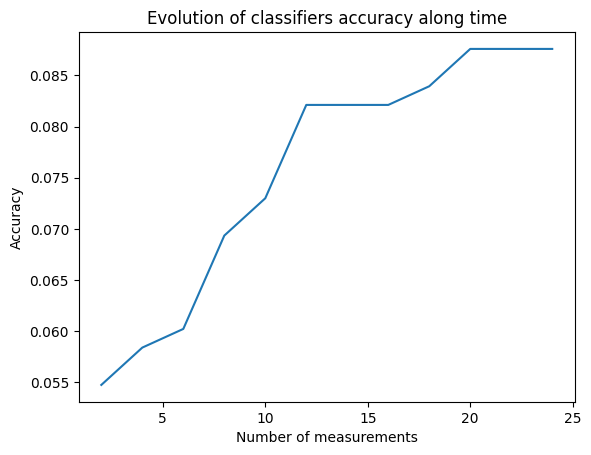

In [16]:
classes = [cc.predict(train_x[val_index:val_index+50, :length]) for length in cc.models_input_lengths]
scores = [np.count_nonzero(model_classes==train_y[val_index:val_index+50])/test_y.shape[0] for model_classes in classes]
plt.xlabel("Number of measurements")
plt.ylabel("Accuracy")
plt.title("Evolution of classifiers accuracy along time")
plt.plot(cc.models_input_lengths, scores)

#### Get the trigger model training data

Once arrived at this point, the ChronologicalClassifiers object's 'predict()' method can be used to classify time series of all lengths contained in the "models_input_lengths" argument.

However, in order to train our trigger model, we need to obtain the array X_pred of shape (N, T, P) of the predicetd class probability vectors of all time series at every considered timestamps x, where N is the number of time series, T the number of input lengths that were used for prediction and P the predicted class probabilities vectors. To do this with use the 'predict_proba()' method.

In [17]:
class_probabilities = np.array([cc.predict_proba(train_x[val_index:,:length]) for length in cc.models_input_lengths])
class_probabilities = np.transpose(class_probabilities, (1,0,2))
print(class_probabilities[0])
print(class_probabilities.shape)

[[1.   0.  ]
 [0.69 0.31]
 [0.87 0.13]
 [0.85 0.15]
 [0.94 0.06]
 [0.97 0.03]
 [0.98 0.02]
 [0.97 0.03]
 [0.98 0.02]
 [1.   0.  ]
 [0.99 0.01]
 [1.   0.  ]]
(274, 12, 2)


#### Initialize Trigger Model costs

Once we obtained the training data for the trigger model, we can now define the cost of misclassifying and delaying the decision to use with the EconomyGammma trigger model as we did earlier.

In contrast to the EarlyClassifier class however, the EconomyGamma object takes as input a series of costs matrices, representing the cost of classifying the wrong class at each considered time step.

In order to convert our two cost objects to an array of cost_matrices, we can use the create_cost_matrix function from the trigger_model.py script by inputing the input lengths of our measurements and our costs.

In [18]:
misclassification_cost = [[0, 10],
                          [10, 0]]

def delay_cost(series_length):
    return series_length * .1

cost_matrices = create_cost_matrices(cc.models_input_lengths, misclassification_cost, delay_cost)

#### Initialize trigger model

In addition to the cost matrices, the trigger model can be instantiated with the following parameters:
- models_series_lengths: array containing the time series lengths that the trigger model will be trained on. In our case, these should be the same as the classifiers'.
- nb_intervals: An hyperparameter corresponding to the number of groups to aggregate the training time series into (DEFAULT=5).
- aggregation_function = Function to aggregate the probabilities of each class for each time series prediction in the multiclass case. (DEFAULT='max')

For better understanding of the inner workings of EconomyGamma, we recommend once more the publication in which it was introduced:

Early classification of time series, Youssef Achenchabe, Alexis Bondu, Antoine Cornuéjols, Asma Dachraoui. Machine Learning 110.6 (2021): 1481-1504.

In [19]:
tm = EconomyGamma(cost_matrices,
                  cc.models_input_lengths,
                  nb_intervals=3, 
                  aggregation_function='gini')

#### Fitting the trigger model

The training of EconomyGamma can be done using the matrix we computed earlier. Since the input contains vectors of class probabilities, a parameter 'classes_' mapping the name of a class label to its order in the probability vectors may be needed.

- X_pred: Array of shape (N, T, P) with N the number of time series, T the number of input lengths that were used for prediction and P the predicted class probabilities vectors.
- y: Array of N labels corresponding to the N time series predicted in X_pred.
- classes_: Array showing the names of classes in the same order as the probabilities in X_pred.

In [20]:
tm.fit(class_probabilities, train_y[val_index:], classes_=cc.classes_)

#### tm.get_params
Details about the attributes can be found in the code documentation for the EconomyGamma class.

In [21]:
tm.get_params()

{'cost_matrices': array([[[ 0.2, 10.2],
         [10.2,  0.2]],
 
        [[ 0.4, 10.4],
         [10.4,  0.4]],
 
        [[ 0.6, 10.6],
         [10.6,  0.6]],
 
        [[ 0.8, 10.8],
         [10.8,  0.8]],
 
        [[ 1. , 11. ],
         [11. ,  1. ]],
 
        [[ 1.2, 11.2],
         [11.2,  1.2]],
 
        [[ 1.4, 11.4],
         [11.4,  1.4]],
 
        [[ 1.6, 11.6],
         [11.6,  1.6]],
 
        [[ 1.8, 11.8],
         [11.8,  1.8]],
 
        [[ 2. , 12. ],
         [12. ,  2. ]],
 
        [[ 2.2, 12.2],
         [12.2,  2.2]],
 
        [[ 2.4, 12.4],
         [12.4,  2.4]]]),
 'models_input_lengths': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24]),
 'nb_intervals': 3,
 'aggregation_function': <function trigger_models.gini(probas)>,
 'thresholds': array([[0.31, 0.79],
        [0.31, 0.76],
        [0.35, 0.72],
        [0.36, 0.81],
        [0.34, 0.84],
        [0.24, 0.9 ],
        [0.16, 0.92],
        [0.13, 0.92],
        [0.14, 0.92],
        [0.05, 0

#### Predicting

Similarly to before, we truncate each time series in the test dataset to a random size.

In order to predict the trigger time of the time series, we first predict their probability vectors using the 'predict_proba()' method of our ChronologicalClassifiers object. Just as before, the input is a dataset of time series of various sizes to predict as an array of shape (N * max_T) where N is the number of time series, max_T the maximum number of measurements in a time series and where empty values are filled with nan. The dataset can also be a pandas DataFrame or a list of lists.

We can then use the output of the 'predict_proba()' method of our ChronologicalClassifers object as input for the EconoyGamma 'predict' function. In addition to this input, we also provide an array containing the length of each time series in the original training set, since this information is lost in the trigger model train set.

The trigger model predict method outputs both the information about triggering as well as the expected costs.

In [22]:
test_x_with_random_lengths = [ts[:np.random.randint(1, cc.max_series_length+1)] for ts in test_x]
actual_lengths = [len(ts) for ts in test_x_with_random_lengths]

probas = cc.predict_proba(test_x_with_random_lengths)
triggers, costs = tm.predict(probas, actual_lengths)

C:\Users\gjfh9393\Desktop\ml_edm library\code\classification.py:383: UserWarning: Some time series were truncated during prediction since no classifier was fitted for their lengths.
  warn("Some time series were truncated during prediction since no classifier was fitted for their lengths.")
C:\Users\gjfh9393\Desktop\ml_edm library\code\classification.py:385: UserWarning: Some time series are of insufficient length for prediction; returning prior probabilities instead.
  warn("Some time series are of insufficient length for prediction; returning prior probabilities instead.")
C:\Users\gjfh9393\Desktop\ml_edm library\code\trigger_models.py:390: UserWarning: Some predictions lengths were unknown to the trigger model. Last known length was assumed
  warn("Some predictions lengths were unknown to the trigger model. Last known length was assumed")
C:\Users\gjfh9393\Desktop\ml_edm library\code\trigger_models.py:392: UserWarning: Some predictions lengths where below that of the first length kn

#### Checking the class probabilities vectors

This information is the one outputed by the ChronologicalClassifiers object after using 'predict_proba()'.

In [23]:
probas

array([[0.58, 0.42],
       [0.72, 0.28],
       [0.77, 0.23],
       ...,
       [0.62, 0.38],
       [0.01, 0.99],
       [0.11, 0.89]])

#### Checking triggering

Is it the right time to trigger a decision (True) or should it be delayed (False)?

In [24]:
triggers

array([False, False, False, False,  True,  True, False,  True, False,
        True,  True,  True, False,  True, False,  True,  True, False,
       False,  True, False,  True, False,  True,  True,  True,  True,
        True, False, False, False, False,  True, False,  True,  True,
        True, False, False,  True, False, False,  True, False,  True,
       False, False, False, False,  True, False,  True, False, False,
        True,  True, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False, False,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False, False,  True, False, False, False, False, False,  True,
       False,  True, False, False, False, False, False, False,  True,
       False,  True, False,  True, False, False, False,  True,  True,
        True, False, False,  True, False,  True, False,  True,  True,
        True,  True, False, False, False,  True,  True, False,  True,
       False,  True,

#### Checking estimated trigger times for predictions

By using argmin on the costs forecasted by EconomyGamma, one can see the number of time steps in which the triggering may happen.

In [25]:
np.array([np.argmin(series_expected_costs) for series_expected_costs in costs])

array([3, 4, 4, 5, 0, 0, 6, 0, 3, 0, 0, 0, 3, 0, 3, 0, 0, 1, 3, 0, 5, 0,
       3, 0, 0, 0, 0, 0, 4, 4, 2, 1, 0, 4, 0, 0, 0, 2, 5, 0, 5, 4, 0, 1,
       0, 4, 3, 5, 5, 0, 4, 0, 5, 5, 0, 0, 4, 5, 3, 4, 3, 2, 1, 0, 3, 3,
       6, 4, 0, 6, 5, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4, 4, 1, 0, 3, 1, 1, 5,
       5, 0, 4, 0, 5, 4, 3, 6, 6, 5, 0, 4, 0, 4, 0, 4, 3, 3, 0, 0, 0, 4,
       5, 0, 6, 0, 4, 0, 0, 0, 0, 4, 3, 4, 0, 0, 4, 0, 5, 0, 4, 4, 0, 4,
       0, 0, 0, 0, 1, 0, 5, 0, 5, 0, 4, 0, 0, 3, 0, 0, 3, 3, 0, 4, 0, 0,
       4, 5, 3, 0, 6, 3, 5, 0, 6, 0, 0, 5, 0, 2, 6, 1, 6, 0, 6, 0, 0, 1,
       3, 1, 0, 0, 0, 6, 0, 2, 4, 0, 6, 0, 1, 3, 4, 5, 0, 0, 1, 6, 6, 6,
       0, 0, 0, 0, 3, 0, 4, 0, 4, 2, 0, 2, 0, 0, 4, 0, 3, 4, 0, 4, 0, 2,
       5, 6, 3, 5, 0, 3, 0, 0, 1, 0, 1, 0, 0, 4, 0, 2, 3, 0, 6, 0, 0, 0,
       0, 5, 4, 4, 3, 5, 0, 0, 0, 1, 5, 0, 6, 3, 4, 4, 0, 2, 4, 0, 0, 0,
       0, 0, 6, 0, 4, 0, 0, 4, 0, 0, 3, 4, 5, 3, 4, 0, 5, 0, 0, 0, 4, 0,
       3, 4, 6, 0, 6, 4, 0, 3, 5, 0, 5, 0, 0, 3, 0,